# Seeds: Random effect logistic regression

Floran Defossez, Sebastien Roig, Gatien Chopard, Natacha Gougeon

## Description des données

A travers ce jeu de données, nous étudions la germination de graines sur un total de 21 assiettes. Deux types de graines sont testés (seed O. aegyptiaco 75 et seed O. aegyptiaco 73) ainsi que deux racines (haricot et concombre), résultant en un total de 4 combinaisons type de graine/racine testées.

## Descriptions du modèle

## Implémentation

In [62]:
import numpy as np
from scipy.stats import invgamma
import matplotlib.pyplot as plt
import pandas as pd

In [63]:
def pi(alpha0, alpha1, alpha2, alpha12, bi, x1, x2):
    s = alpha0 + alpha1*x1 + alpha2*x2 + alpha12*x1*x2 + bi
    return 1/(1+np.exp(-s))

def log_vraisemblance_bi(data, alpha0, alpha1, alpha2, alpha12, b, i):
    r, n, x1, x2 = data
    vraisemblance = 0
    vraisemblance += r[i]*np.log(pi(alpha0, alpha1, alpha2, alpha12, b[i], x1[i], x2[i]))
    vraisemblance += (n[i] - r[i])*(np.log(1 - pi(alpha0, alpha1, alpha2, alpha12, b[i], x1[i], x2[i])))
    return vraisemblance

def log_vraisemblance(data, alpha0, alpha1, alpha2, alpha12, b):
    r, n, x1, x2 = data
    N=len(r)
    vraisemblance = 0
    for i in range(N):
        vraisemblance += r[i]*np.log(pi(alpha0, alpha1, alpha2, alpha12, b[i], x1[i], x2[i]))
        vraisemblance += (n[i] - r[i])*(np.log(1 - pi(alpha0, alpha1, alpha2, alpha12, b[i], x1[i], x2[i])))
    return vraisemblance


def gibbs_seed(nchain, hyper, init1, init_bi, data, random_walk):
    chain1 = np.zeros(shape = (nchain+1, 5)) #alpha0, alpha1, alpha2, alpha12, tau
    chain_bi = np.zeros(shape = (nchain+1, 21)) #bi

    #variances pour la marche aléatoire des alpha et des bi
    random_walk1, random_walkbi = random_walk[0], random_walk[1]

    N = 21
    acceptance_rate1 = np.zeros(shape = 4) #acceptance rate pour alpha0, alpha1, alpha2, alpha12, tau est toujours accepté
    acceptance_rate_bi = np.zeros(shape = N) #acceptance rate pour les bi

    chain1[0,:] = init1
    chain_bi[0,:] = init_bi

    sigma0, sigma1, sigma2, sigma12, a, b = hyper #variances pour les lois normales des alpha et alpha/beta de l'inverse gamma pour tau


    for i in range(nchain):

        #mise à jour des bi
        chain_bi[i+1, :] = chain_bi[i, :]
        for j in range(N):
            xt = chain_bi[i,j]
            prop = xt + np.random.normal(scale = random_walkbi[j])

            b_prop = np.copy(chain_bi[i+1]) #vecteur des bi dans lequel on remplace bj par la proposition
            b_prop[j] = prop

            num = -prop**2/(2*chain1[i, 4]) + log_vraisemblance_bi(data, chain1[i,0], chain1[i,1], chain1[i,2], chain1[i,3], b_prop, j)
            den = -xt**2/(2*chain1[i, 4]) + log_vraisemblance_bi(data, chain1[i,0], chain1[i,1], chain1[i,2], chain1[i,3], chain_bi[i+1], j)
            
            prob_acceptation = np.exp(num - den) #probabilité alpha de MH d'accepter la proposition
            if prob_acceptation > np.random.uniform():
                chain_bi[i+1, j] = prop
                acceptance_rate_bi[j]+=1
            else :
                chain_bi[i+1, j] = xt

        #mise à jour de alpha0
        xt = chain1[i,0]
        prop = xt + np.random.normal(scale = random_walk1[0])

        num = -prop**2/(2*sigma0) + log_vraisemblance(data, prop, chain1[i,1], chain1[i,2], chain1[i,3], chain_bi[i+1])
        den = -xt**2/(2*sigma0) + log_vraisemblance(data, xt, chain1[i,1], chain1[i,2], chain1[i,3], chain_bi[i+1])
        
        prob_acceptation = np.exp(num - den) #probabilité alpha de MH d'accepter la proposition
        if prob_acceptation > np.random.uniform():
            chain1[i+1, 0] = prop
            acceptance_rate1[0]+=1
        else :
            chain1[i+1, 0] = xt

        #mise à jour de alpha1
        xt = chain1[i,1]
        prop = xt + np.random.normal(scale = random_walk1[1])

        num = -prop**2/(2*sigma1) + log_vraisemblance(data, chain1[i+1,0], prop, chain1[i,2], chain1[i,3], chain_bi[i])
        den = -xt**2/(2*sigma1) + log_vraisemblance(data, chain1[i+1,0], xt, chain1[i,2], chain1[i,3], chain_bi[i])
        
        prob_acceptation = np.exp(num - den) #probabilité alpha de MH d'accepter la proposition
        if prob_acceptation > np.random.uniform():
            chain1[i+1, 1] = prop
            acceptance_rate1[1]+=1
        else :
            chain1[i+1, 1] = xt

        #mise à jour de alpha2
        xt = chain1[i,2]
        prop = xt + np.random.normal(scale = random_walk1[2])

        num = -prop**2/(2*sigma2) + log_vraisemblance(data, chain1[i+1,0], chain1[i+1,1], prop, chain1[i,3], chain_bi[i])
        den = -xt**2/(2*sigma2) + log_vraisemblance(data, chain1[i+1,0], chain1[i+1,1], xt, chain1[i,3], chain_bi[i])
        
        prob_acceptation = np.exp(num - den) #probabilité alpha de MH d'accepter la proposition
        if prob_acceptation > np.random.uniform():
            chain1[i+1, 2] = prop
            acceptance_rate1[2]+=1
        else :
            chain1[i+1, 2] = xt

        #mise à jour de alpha12
        xt = chain1[i,3]
        prop = xt + np.random.normal(scale = random_walk1[3])

        num = -prop**2/(2*sigma12) + log_vraisemblance(data, chain1[i+1,0], chain1[i+1,1], chain1[i+1,2], prop, chain_bi[i])
        den = -xt**2/(2*sigma12) + log_vraisemblance(data, chain1[i+1,0], chain1[i+1,1], chain1[i+1,2], xt, chain_bi[i])
        
        prob_acceptation = np.exp(num - den) #probabilité alpha de MH d'accepter la proposition
        if prob_acceptation > np.random.uniform():
            chain1[i+1, 3] = prop
            acceptance_rate1[3]+=1
        else :
            chain1[i+1, 3] = xt

        #mise à jour de tau
        a_star = a + N/2
        b_star = b + np.sum(chain_bi[i+1]**2)/2
        chain1[i+1, 4] = invgamma.rvs(a = a_star, scale = b_star)

    return chain1, chain_bi, 1/nchain*acceptance_rate1, 1/nchain*acceptance_rate_bi

In [64]:
r = np.array([10, 23, 23, 26, 17, 5, 53, 55, 32, 46, 10, 8, 10, 8, 23, 0, 3, 22, 15, 32, 3])
n = np.array([39, 62, 81, 51, 39, 6, 74, 72, 51, 79, 13, 16, 30, 28, 45, 4, 12, 41, 30, 51, 7])
x1 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) #seed type (seed 75 ou seed 73)
x2 = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]) #root extract (bean ou cucumber)

N=len(r)

data = np.array([r, n, x1, x2])
print(data)
print(np.shape(data))

hyper = [10**3, 10**3, 10**3, 10**3, 1, 1] #sigma0, sigma1, sigma2, sigma12 (tous déja au carré), a, b
#init1 = [np.random.normal(scale = hyper[i]) for i in range(4)]
#init1.append(invgamma.rvs(a = hyper[4], scale = hyper[5]))
#init1=np.array(init1)
#init_bi = np.random.normal(scale = np.sqrt(init1[-1]), size = N)
init1 = np.ones(5)
init_bi = np.ones(N)
nchain = 10000
random_walk = [[0.25,0.5,0.5,0.5],[1,1,1,1,1,2,1,1,1,1,2,2,1,2,1,2,2,1,1,1,2]]
#random_walk = [[1,1,1,1],[1,1,1,1,1,2,1,1,1,1,2,2,1,2,1,2,2,1,1,1,2]]

[[10 23 23 26 17  5 53 55 32 46 10  8 10  8 23  0  3 22 15 32  3]
 [39 62 81 51 39  6 74 72 51 79 13 16 30 28 45  4 12 41 30 51  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  1  1  1  1  1  1  0  0  0  0  0  1  1  1  1  1]]
(4, 21)


In [77]:
chain1, chain_bi, acceptance_rate1, acceptance_rate_bi = gibbs_seed(nchain = nchain, hyper = hyper, init1 = init1, init_bi = init_bi, data = data, random_walk = random_walk)
print(acceptance_rate1)
print(acceptance_rate_bi)

[0.3391 0.3093 0.2603 0.3965]
[0.3413 0.2837 0.2728 0.2967 0.3169 0.284  0.2813 0.293  0.2962 0.2588
 0.253  0.2367 0.3632 0.2064 0.3247 0.3035 0.241  0.3245 0.3543 0.3049
 0.2804]


Text(0.5, 1.0, 'Alpha12')

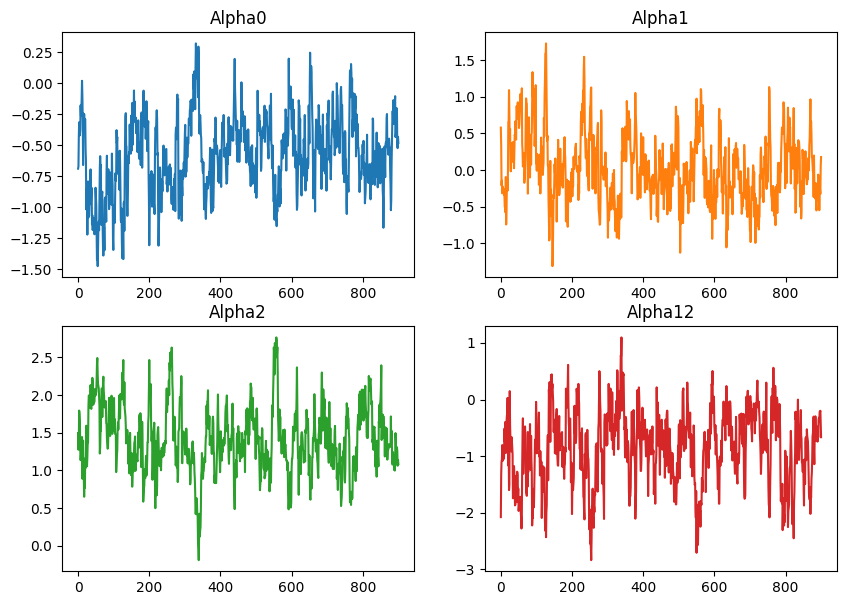

In [79]:
burning = 1000 #on enlève les premières valeurs
lag = 10 #on ne conserve que 1 états sur lag afin de réduire les effets de dépendance.
x = np.arange(burning, nchain+1, lag)
x = np.array([i for i in range(len(x))])

final_chain1 = chain1[burning::lag, :]
final_chain_bi = chain_bi[burning::lag, :]

fig, axs = plt.subplots(2, 2, figsize = (10, 7))
axs[0, 0].plot(x, final_chain1[:,0])
axs[0, 0].set_title('Alpha0')
axs[0, 1].plot(x, final_chain1[:,1], 'tab:orange')
axs[0, 1].set_title('Alpha1')
axs[1, 0].plot(x, final_chain1[:,2], 'tab:green')
axs[1, 0].set_title('Alpha2')
axs[1, 1].plot(x, final_chain1[:,3], 'tab:red')
axs[1, 1].set_title('Alpha12')

Text(0.5, 1.0, 'b0')

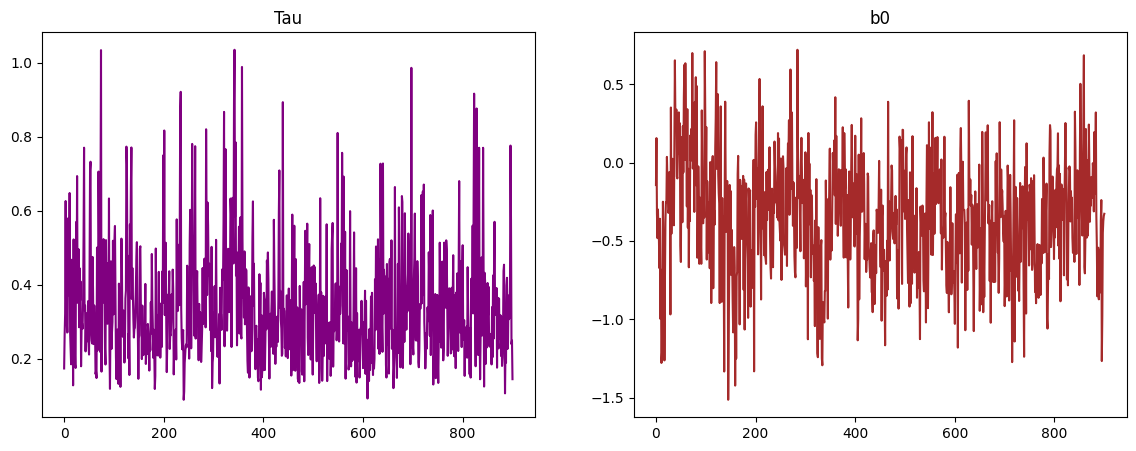

In [87]:
fig, axs = plt.subplots(1, 2, figsize = (14, 5))
axs[0].plot(x, final_chain1[:,4], c='purple')
axs[0].set_title('Tau')
axs[1].plot(x, final_chain_bi[:,0], c='brown')
axs[1].set_title('b0')

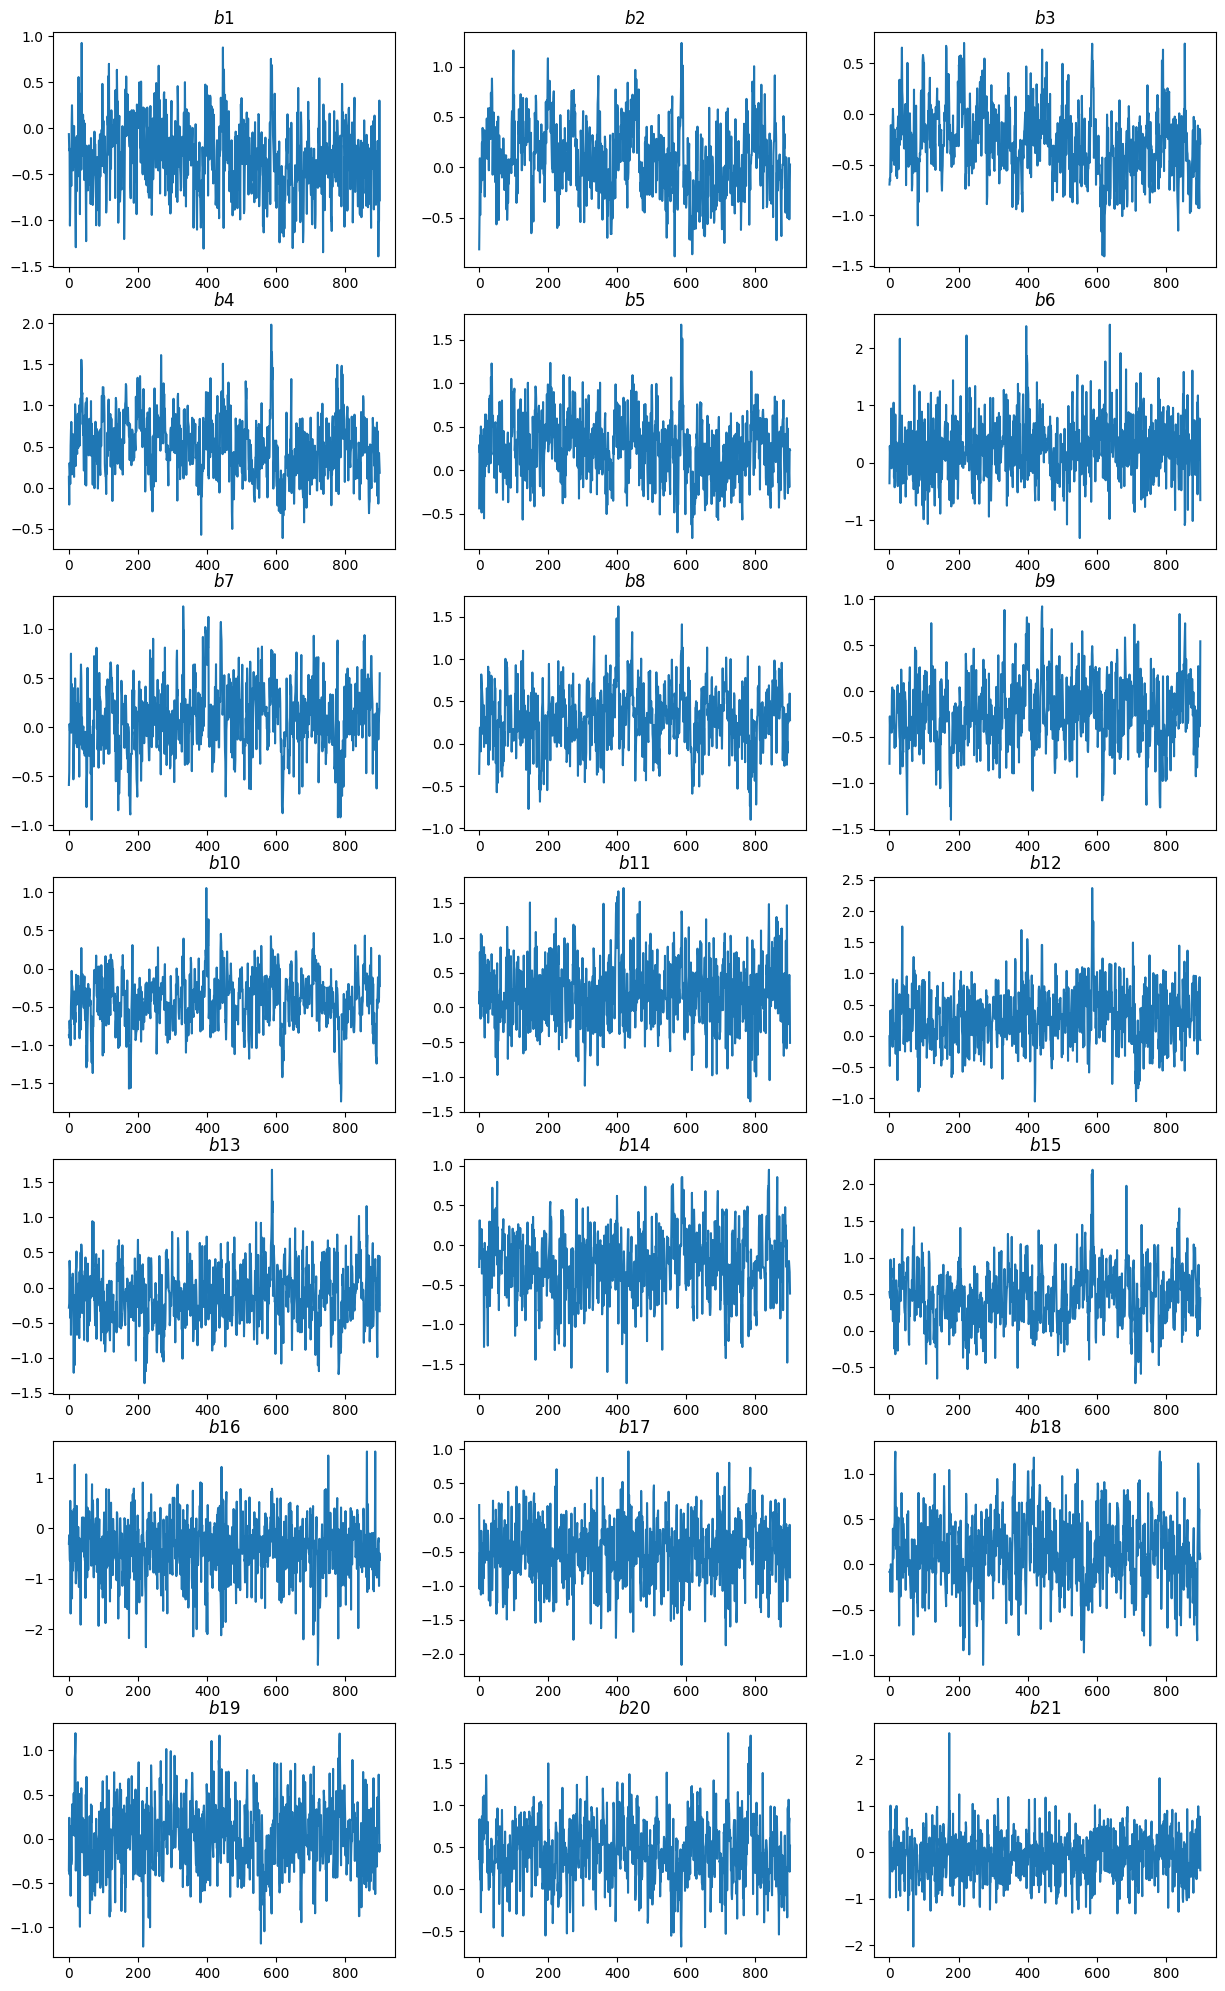

In [69]:
fig, axs = plt.subplots(7, 3, figsize = (15, 25))
for i in range(N):
    axs[i//3, i%3].plot(x, final_chain_bi[:,i])
    axs[i//3, i%3].set_title(f"$b{i+1}$")

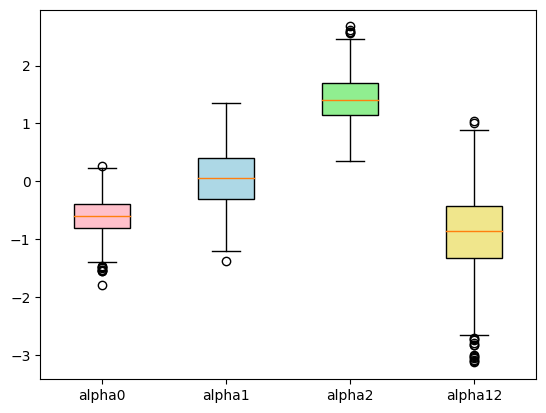

In [70]:
fig, ax = plt.subplots()
bp1 = ax.boxplot(final_chain1[:,0:4], patch_artist=True, labels = ['alpha0', 'alpha1', 'alpha2', 'alpha12']);

colors = ['pink', 'lightblue', 'lightgreen', 'khaki']
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)

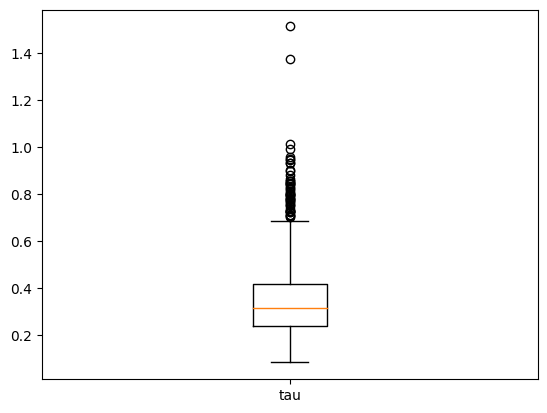

In [71]:
plt.boxplot(final_chain1[:,4], labels = ['tau']);

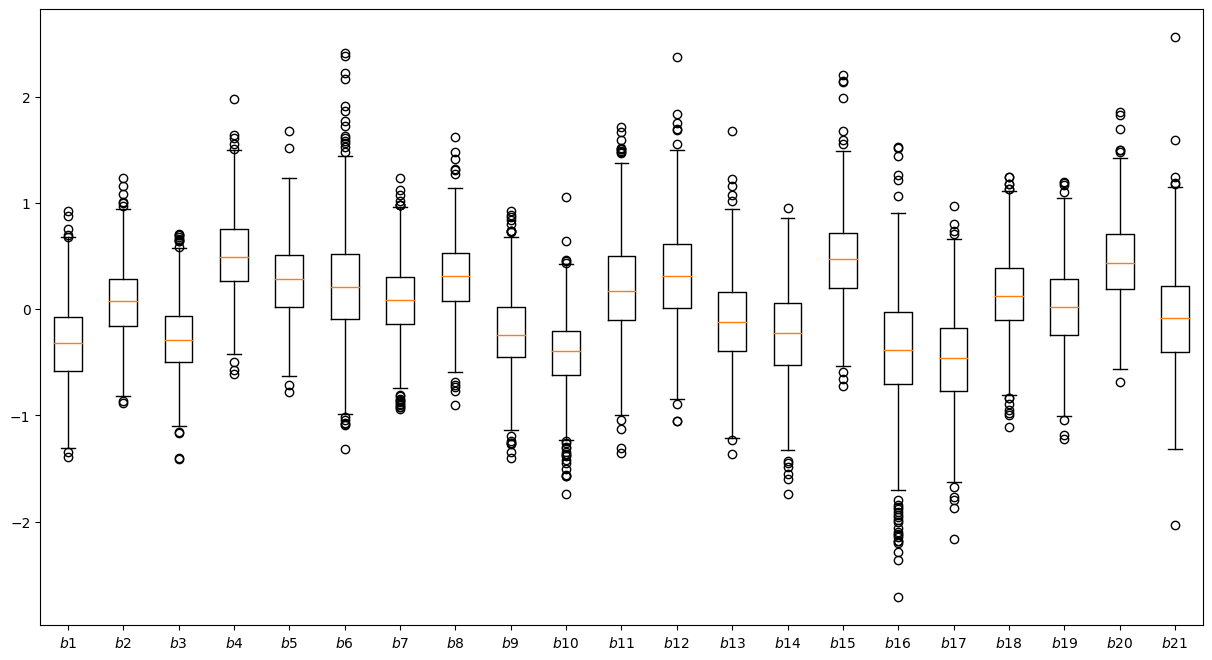

In [72]:
fig, ax = plt.subplots(figsize = (15,8))
bp1 = ax.boxplot(final_chain_bi, labels = [f"$b{i+1}$" for i in range(len(chain_bi[0]))]);

In [73]:
#On calcule les moyennes et variance pour les alpha et pour tau. n ne s'intérèsse pas aux bi ici car ce sont des variables latentes.

moyenne_attendue = [-0.5525, 0.08382, 1.346, -0.8165, 0.267] #moyennes fournies pour ce modèle sur le pdf du sujet
ecart_type_attendu = [0.1852, 0.3031, 0.2564, 0.4109, 0.1471] #écarts types fournis pour ce modèle sur le pdf du sujet

result_table = np.zeros(shape = (5,4))
for i in range(5):
    result_table[i,0] = np.mean(final_chain1[:,i])
    result_table[i,1] = np.sqrt(np.var(final_chain1[:,i]))
    result_table[i,2] = moyenne_attendue[i]
    result_table[i,3] = ecart_type_attendu[i]
result_table = pd.DataFrame(data = result_table, index =['alpha0', 'alpha1', 'alpha2', 'alpha12', 'tau'], columns = ['moyenne obtenue', 'écart type obtenu', 'moyenne sujet', 'écart type sujet'] )
result_table

,moyenne obtenue,écart type obtenu,moyenne sujet,écart type sujet
alpha0,-0.611952,0.312315,-0.55250,0.1852
alpha1,0.053730,0.489006,0.08382,0.3031
alpha2,1.438063,0.410535,1.34600,0.2564
alpha12,-0.905148,0.705884,-0.81650,0.4109
tau,0.354943,0.170077,0.26700,0.1471


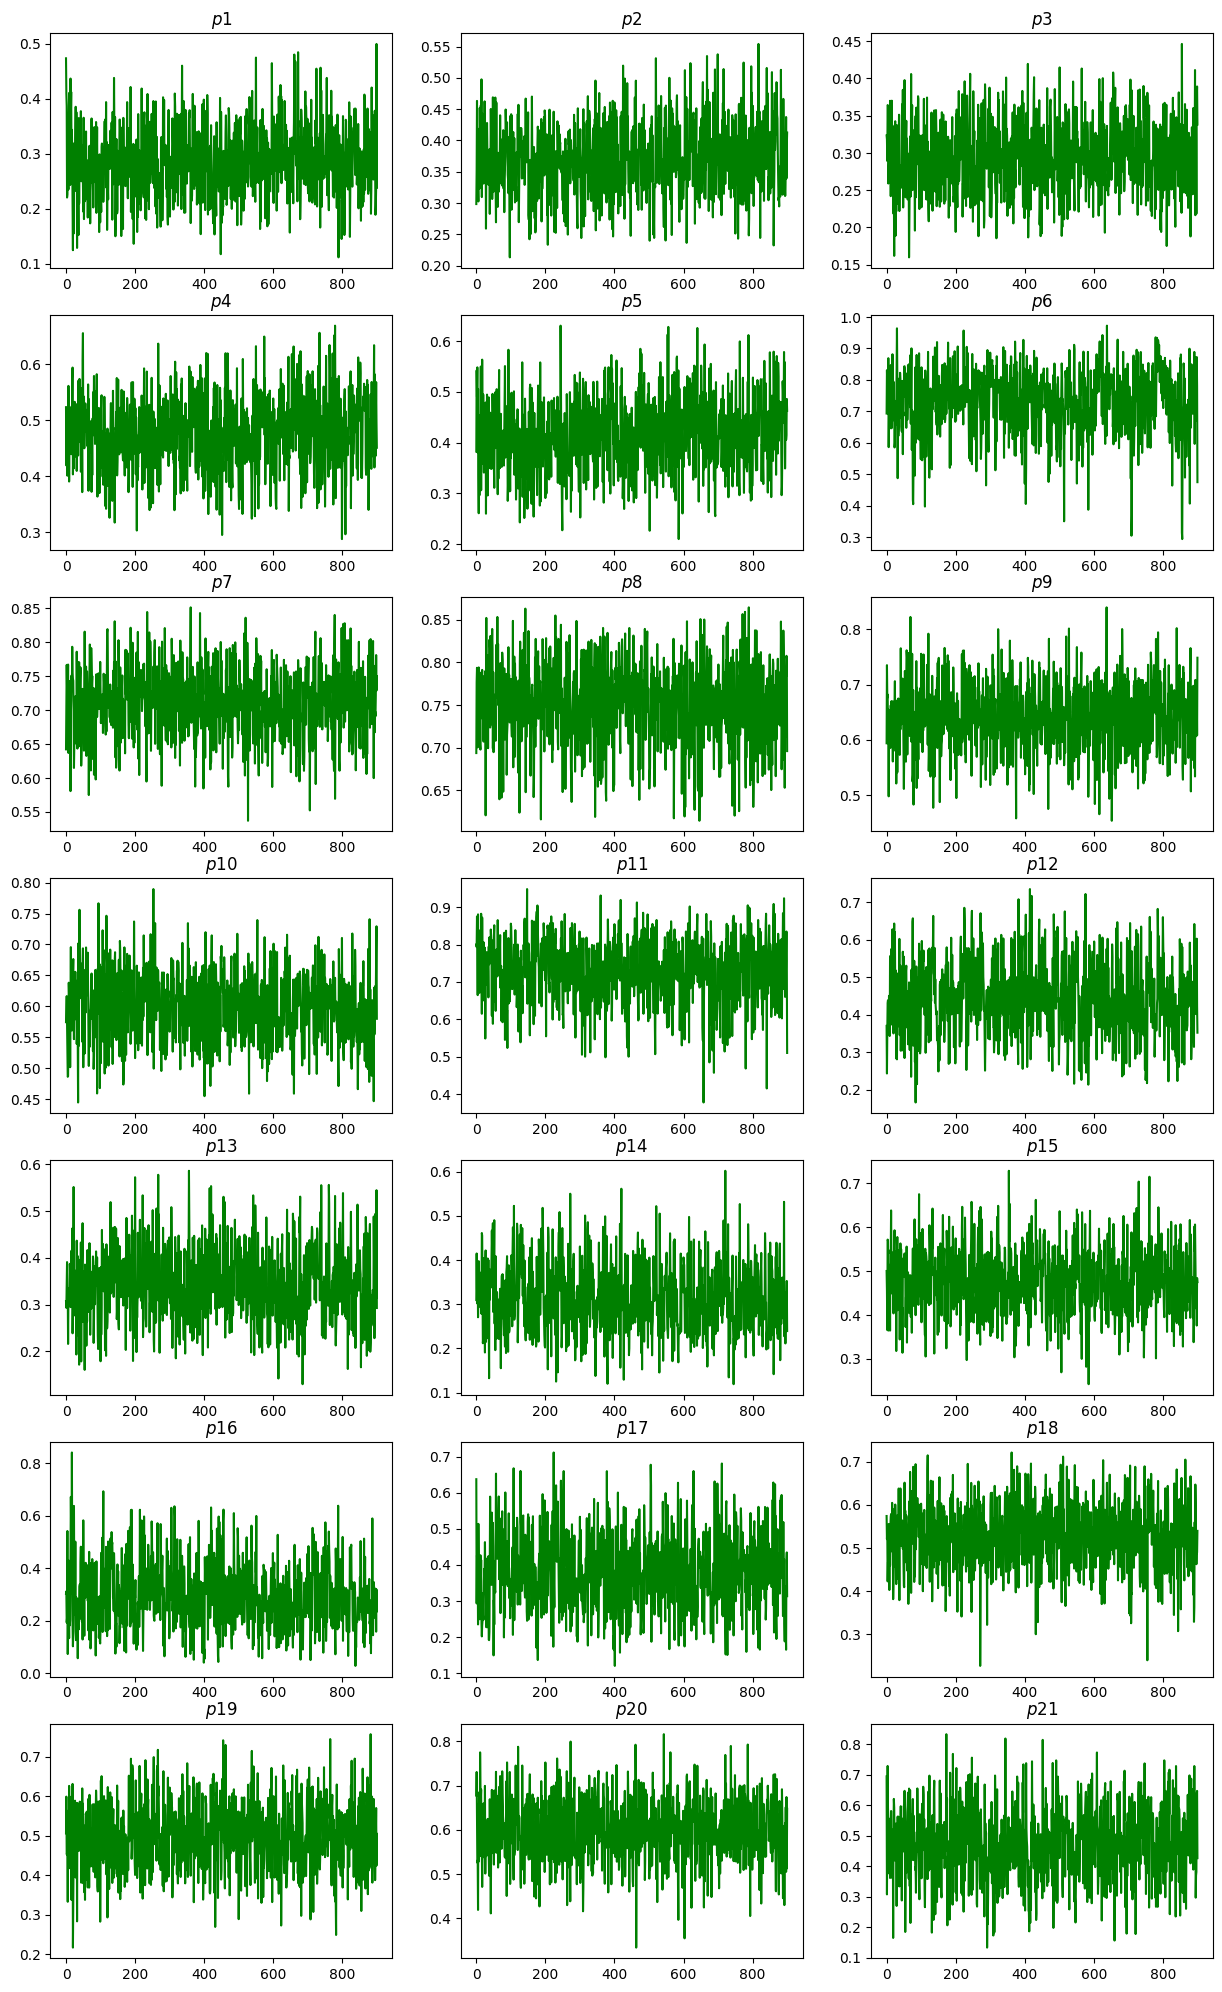

In [74]:
'''def pi(alpha0, alpha1, alpha2, alpha12, bi, x1, x2):
    s = alpha0 + alpha1*x1 + alpha2*x2 + alpha12*x1*x2 + bi
    return 1/(1+np.exp(-s))'''

#Calcul de la distribution des pi :
chain_pi = np.zeros(shape = (len(final_chain1), N))
for i in range(N):
    chain_pi[:,i] = pi(final_chain1[:,0], final_chain1[:,1], final_chain1[:,2], final_chain1[:,3], final_chain_bi[:,i], x1[i], x2[i])

fig, axs = plt.subplots(7, 3, figsize = (15, 25))
for i in range(N):
    axs[i//3, i%3].plot(x, chain_pi[:,i], c='green')
    axs[i//3, i%3].set_title(f"$p{i+1}$")

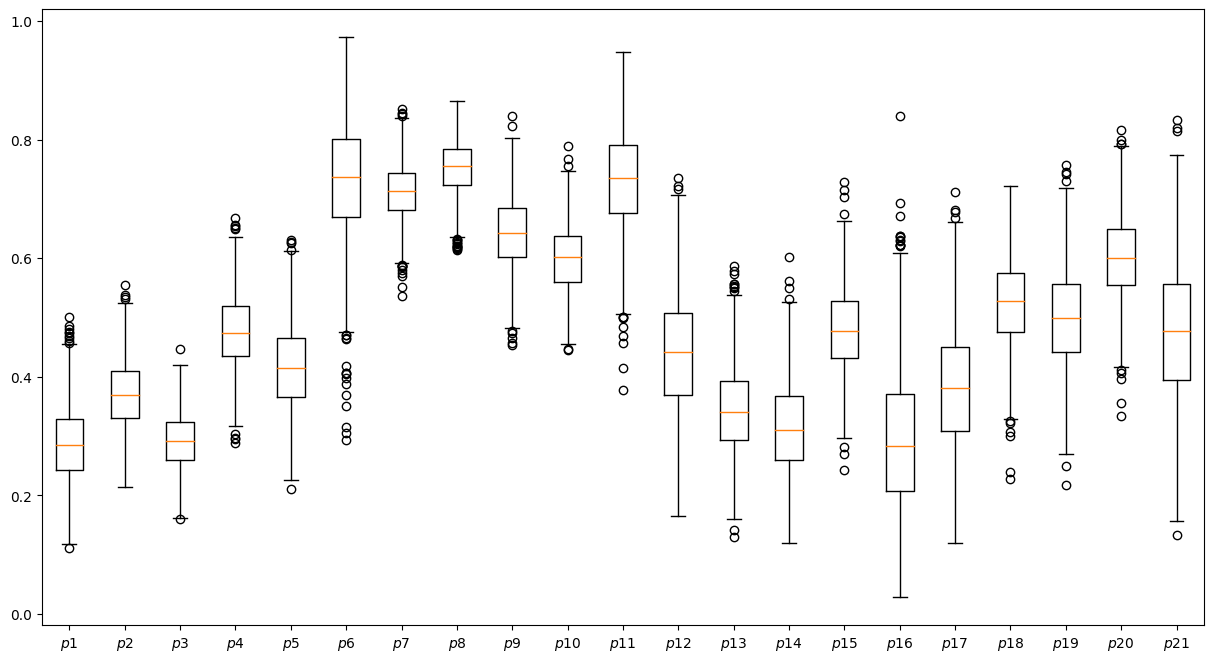

In [75]:
fig, ax = plt.subplots(figsize = (15,8))
bp1 = ax.boxplot(chain_pi, labels = [f"$p{i+1}$" for i in range(len(chain_bi[0]))]);

In [89]:
result_table = np.zeros(shape = (N,2))
for i in range(N):
    result_table[i,0] = np.mean(chain_pi[:,i])
    result_table[i,1] = np.sqrt(np.var(chain_pi[:,i]))
result_table_df = pd.DataFrame(data = result_table, index =['p'+str(i) for i in range(N)], columns = ['moyenne', 'écart type'] )
result_table_df

,moyenne,écart type
p0,0.285930,0.063753
p1,0.370688,0.057292
p2,0.293656,0.047422
p3,0.475887,0.064052
p4,0.416560,0.071880
p5,0.729480,0.102827
p6,0.711495,0.049622
p7,0.751396,0.047722
p8,0.642222,0.061449
p9,0.599821,0.054785


In [92]:
#On regroupe à présent les pi selon le couple (seed type, root extract)
final_result_table = np.zeros(shape = (4,2))
final_result_table[0,0] = np.mean(result_table[0:5,0])
final_result_table[0,1] = np.mean(result_table[0:5,1])
final_result_table[1,0] = np.mean(result_table[5:11,0])
final_result_table[1,1] = np.mean(result_table[5:11,1])
final_result_table[2,0] = np.mean(result_table[11:16,0])
final_result_table[2,1] = np.mean(result_table[11:16,1])
final_result_table[3,0] = np.mean(result_table[16:21,0])
final_result_table[3,1] = np.mean(result_table[16:21,1])

final_result_table_df = pd.DataFrame(data = final_result_table, index =['seed 75 + haricot', 'seed 75 + concombre', 'seed 73 + haricot', 'seed 73 + concombre'], columns = ['moyenne', 'écart type'] )
final_result_table_df

,moyenne,écart type
seed 75 + haricot,0.368544,0.060880
seed 75 + concombre,0.693867,0.066971
seed 73 + haricot,0.375343,0.089900
seed 73 + concombre,0.496412,0.090971
